In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import ot
import os

In [4]:
# from SDEOU import SDE_OU
# from SDECellChemotaxis import SDE_CellChemotaxis

In [5]:
class SDE_General1D(object):
    # parameters :
        # x : (num_cells,) points
        # h : float step size
        # mu : ((num_cells,), float) -> (num_cells,)
        # sigma : ((num_cells,), float) -> (num_cells,)
        # time : float
        # x_bounds : (2,) bounds for cell location

    def __init__(self, x, h, mu, sigma, time, x_bounds=None):
        self.x = x
        self.h = h
        self.mu = mu
        self.sigma = sigma
        self.time = time
        self.x_bounds = x_bounds

        self.num_cells = self.x.shape
    
    def take_step(self,):
        x_step_mu = self.mu(self.x, self.time)
        x_step_sigma = self.sigma(self.x, self.time)
        x_step_delta_w = np.random.normal(0, np.sqrt(self.h), size=(self.num_cells))
        x_step = x_step_mu*self.h + x_step_sigma*x_step_delta_w
        self.x = self.x + x_step

        if self.x_bounds is not None:
            self.x = np.where(self.x < self.x_bounds[0], self.x_bounds[0], self.x)
            self.x = np.where(self.x > self.x_bounds[1], self.x_bounds[1], self.x)
        
        self.time = self.time + self.h


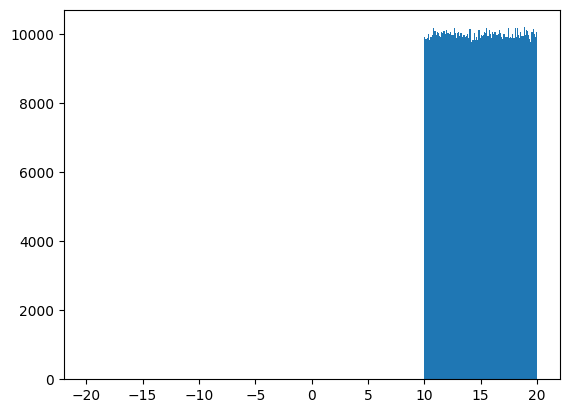

1
2
3
4
5
6
7
8
9
10


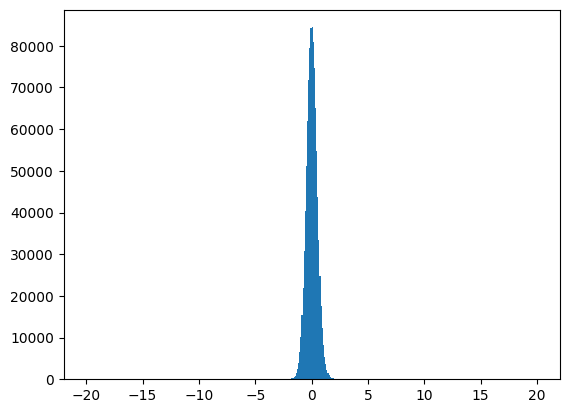

1
2
3
4
5
6
7
8
9
10


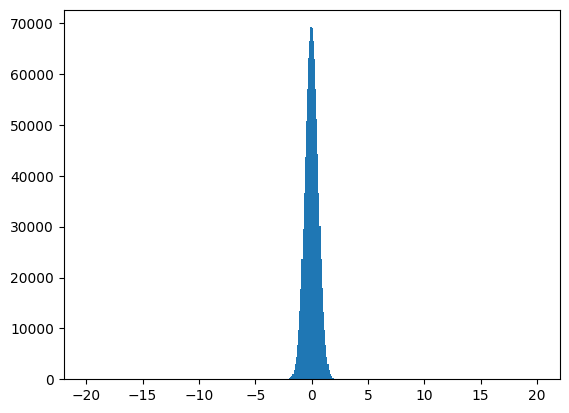

1
2
3
4
5
6
7
8
9
10


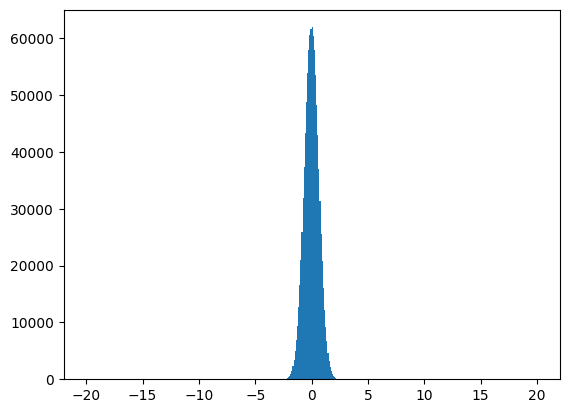

1
2
3
4
5
6
7
8
9
10


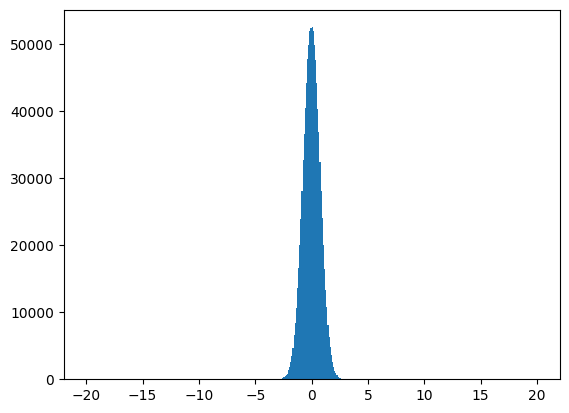

1
2
3
4
5
6
7
8
9
10


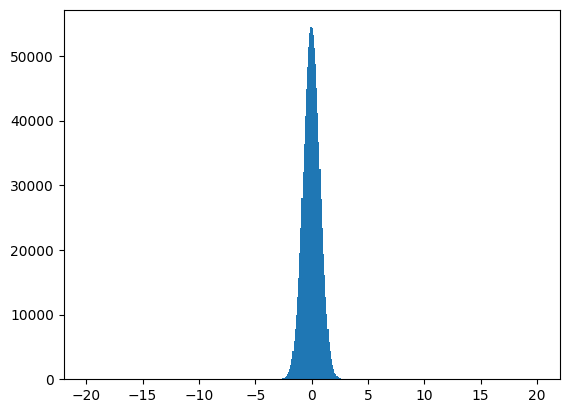

In [8]:
# SDE1D

NUM_PARTS = 1000000
H = 1/128

NUM_NEWTON_STEPS = 5
NUM_STEPS_FOR_ORACLE_STEP = 16
NUM_BURNIN_STEPS = 32

NUM_KRYLOV_DIMS = 10

def p0(x):
    # return np.exp(-x**2/2) + 1/3*np.exp(-(x-2)**2/2) + 1/4*np.exp(-(x-4)**2/4)
    # return np.exp(-x**2/2) + 1/2*np.exp(-(x-2)**2/2) + 1/3*np.exp(-(x-3)**2/2) + 1/4*np.exp(-(x-4)**2/2) + 1/5*np.exp(-(x-5)**2/2)
    return np.exp(-x**2/2) + np.exp(-x**2/128)
def p1(x):
    # return -x*np.exp(-x**2/2) - 1/3*(x-2)*np.exp(-(x-2)**2/2) - 1/4*(x-4)*1/2*np.exp(-(x-4)**2/4)
    # return -x*np.exp(-x**2/2) - 1/2*(x-1)*np.exp(-(x-2)**2/2) - 1/3*(x-3)*np.exp(-(x-3)**2/2) - 1/4*(x-4)*np.exp(-(x-4)**2/2) - 1/5*(x-5)*np.exp(-(x-5)**2/2)
    return 1*(-x*np.exp(-x**2/2) - x*1/64*np.exp(-x**2/128))
def mu(x,t):
    return -x
    # return (1/(x**2/2+0.3))*x-x
    # return (1/(x**2/2+0.3))*x-x + 0.1
    # return -x-0.2*x**3
    # return -x + 2*np.sin(x)
    # return p1(x)/p0(x)
def sigma(x,t):
    return 1

x_newton = np.zeros((NUM_NEWTON_STEPS+1, NUM_PARTS))
HIST_BINS = np.linspace(-20,20,401)

krylov_q = np.zeros((NUM_KRYLOV_DIMS+1,NUM_PARTS))
krylov_w = np.zeros((NUM_KRYLOV_DIMS,NUM_PARTS))
krylov_h = np.zeros((NUM_KRYLOV_DIMS+1,NUM_KRYLOV_DIMS))

x_start_init = np.random.uniform(10,20,size=NUM_PARTS)
x_start = np.sort(x_start_init)
sde1 = SDE_General1D(x_start, H, mu, sigma, 0)

x_newton[0] = x_start
plt.figure()
plt.hist(x_newton[0], bins=HIST_BINS)
plt.show()

for k in range(NUM_NEWTON_STEPS):
    for n in range(NUM_STEPS_FOR_ORACLE_STEP):
        sde1.take_step()
    x_after_one_oracle_step = np.sort(sde1.x) # E(x)
    
    b = -(x_after_one_oracle_step - x_start) # b = -[E_h(x_n) - x_n]
    beta = np.linalg.norm(b)
    krylov_q[0] = b/beta # set q_0 = b / \|b\|

    for j in range(NUM_KRYLOV_DIMS):
        print(j+1)
        DELTA = 1/np.average(krylov_q[j]) # parameter we get to tune
        # print(DELTA)
        x_start_perturbed = x_start + DELTA*krylov_q[j] # x + delta*q_j
        sde1.x = x_start_perturbed
        for n in range(NUM_STEPS_FOR_ORACLE_STEP):
            sde1.take_step()
        x_after_one_oracle_step_perturbed = np.sort(sde1.x) # E(x+delta*q_j)
        krylov_w[j] = (x_after_one_oracle_step_perturbed - x_after_one_oracle_step)/DELTA-krylov_q[j] # w_j = Aq_j = DE_x(q_j) - q_j \approx [E(x+delta*q_j) - E(x)]/delta - q_j
        for i in range(j+1):
            krylov_h[i,j] = np.dot(krylov_w[j],krylov_q[i]) # h_ij = \langle w_j, q_j \rangle
            krylov_w[j] -= krylov_h[i,j]*krylov_q[i] # w_j = h_ij*q_j
        krylov_h[j+1,j] = np.linalg.norm(krylov_w[j]) # h_{j+1,j} = \|w_j\|
        # print(krylov_h[j+1,j])
        if np.abs(krylov_h[j+1,j])<1e-10: # if \|w_j\| is small, break
            m = j+1
            print("BREAKING BECAUSE np.abs(krylov_h[j+1,j]) = " + str(np.abs(krylov_h[j+1,j])))
            krylov_q = krylov_q[0:m]
            krylov_w = krylov_w[0:m]
            krylov_h = krylov_h[0:m+1,0:m]
            break
        krylov_q[j+1] = krylov_w[j]/krylov_h[j+1,j] # q_{j+1} = w_j/h_{j+1,j}
    m = j+1
    # print("m is " + str(m))
    # print("Shape of H is " + str(np.shape(krylov_h)))
    # print("Shape of V is " + str(np.shape(krylov_q)))
    y_m = np.linalg.lstsq(krylov_h,beta*np.eye(1,m+1,0).reshape(m+1,), rcond=None)[0] # set y_m the minimizer of \|beta*e_1 - H_my_m\|
    
    x_update = krylov_q[0:m].T@y_m
    x_next = x_start + x_update # x_new = x_old + Q@y_m
    
    sde1.x = x_next # reinitialize the SDE object with the new x and burn in
    for n in range(NUM_BURNIN_STEPS):
        sde1.take_step()
    
    x_start = np.sort(sde1.x) # set the burned-in particle locations to be the next "newton iterate" and repeat
    x_newton[k+1] = x_start

    plt.figure()
    plt.hist(x_newton[k+1], bins=HIST_BINS)
    plt.show()

